In [4]:
!pip install pandas

In [5]:
# Create a small, ready-to-run supervised ML demo dataset for peptide–HLA binding (toy example).
# This version saves to ./data/hla_a0201_example.csv (creates the folder if missing).

# 1) Ensure pandas is available (works in Jupyter without restarting)
import sys, subprocess
try:
    import pandas as pd
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas"])
    import pandas as pd

from pathlib import Path

binders = [
    "GILGFVFTL","LLFGYPVYV","NLVPMVATV","SLLMWITQC","FLPSDFFPS","GLCTLVAML","SLYNTVATL",
    "YVLDHLIVV","ILKEPVHGV","ALYVDSLFF","KVLEYVIKV","YLLPAIVHI","CLGGLLTMV","VLAELVKQI",
    "ELAGIGILTV","IMDQVPFSV","RLRAEAQVK","SIFSYIPSA","KIFGSLAFL","LLGATCMFV","YLQPRTFLL",
    "ALWGPDPAAA","YVFVVLLSS","TLNAWVKVV","ILAKFLHWL","LFGYPVYVL","FMYSDFHFI","LLFGYPVYV",
    "VLSPPLVLF","YLLPRRGPR"
]

non_binders = [
    "ACDEFGHIK","LMNPQRSTV","WYACDFGHK","NPQRSTVWY","GGGGGGGGG","PPPPPPPPP","AAAAAAAAA",
    "SSSSSSSSS","TTTTTTTTT","CCCCCCCCC","VVVVVVVVV","MMMMMMMMM","KKKKKKKKK","RRRRRRRRR",
    "EEEQQQEEE","HHPHHHPHH","DIDIDIDID","NQNQNQNQN","YGYGYGYGY","ILGSDTQKM","QWERTYIPD",
    "ASDFGHJKL","PLMVNQRTY","GHTPLMKJI","CNVGTYHQA","LKMNBGFDE","RTYUIOPAS","ZXCVBNMAS",
    "QAZWSXEDC","PLKJHGFDS"
]

data = pd.DataFrame({
    "allele": ["HLA-A*02:01"] * (len(binders) + len(non_binders)),
    "peptide": binders + non_binders,
    "label":   [1]*len(binders) + [0]*len(non_binders)
})

# 2) Save to a local "data" folder next to your notebook
save_dir = Path.cwd() / "data"
save_dir.mkdir(parents=True, exist_ok=True)
csv_path = save_dir / "hla_a0201_example.csv"
data.to_csv(csv_path, index=False)

print(f"Saved dataset to: {csv_path.resolve()}")

# 3) (Optional) Preview the first few rows in Jupyter
data.head()


Saved dataset to: C:\Users\Sourav\data\hla_a0201_example.csv


,allele,peptide,label
0,HLA-A*02:01,GILGFVFTL,1
1,HLA-A*02:01,LLFGYPVYV,1
2,HLA-A*02:01,NLVPMVATV,1
3,HLA-A*02:01,SLLMWITQC,1
4,HLA-A*02:01,FLPSDFFPS,1


In [8]:
!pip install matplotlib scikit-learn


=== LogisticRegression ===
Accuracy: 0.733 | ROC-AUC: 0.839
              precision    recall  f1-score   support

           0      0.833     0.625     0.714         8
           1      0.667     0.857     0.750         7

    accuracy                          0.733        15
   macro avg      0.750     0.741     0.732        15
weighted avg      0.756     0.733     0.731        15


=== RandomForest ===
Accuracy: 0.800 | ROC-AUC: 0.786
              precision    recall  f1-score   support

           0      0.857     0.750     0.800         8
           1      0.750     0.857     0.800         7

    accuracy                          0.800        15
   macro avg      0.804     0.804     0.800        15
weighted avg      0.807     0.800     0.800        15



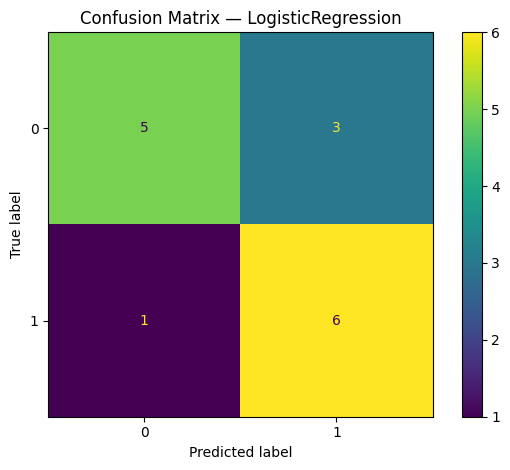


Training complete.


In [10]:
# Train a simple supervised classifier on the toy dataset.
# - One-hot encode amino acids (9-mer peptides only; sequences not length 9 will be trimmed/padded if present)
# - Train/test split
# - Train Logistic Regression and RandomForest
# - Evaluate with accuracy, ROC-AUC, classification report
# - Plot a confusion matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

# Load dataset
df = pd.read_csv(r"C:\Users\Sourav\data\hla_a0201_example.csv")

# Ensure 9-mer length for simplicity
def pad_or_trim(seq, length=9, pad_char="X"):
    if len(seq) == length:
        return seq
    if len(seq) > length:
        return seq[:length]
    return seq + pad_char*(length-len(seq))

df["peptide"] = df["peptide"].astype(str).apply(lambda s: pad_or_trim(s, 9))

# Build feature matrix: position-specific one-hot
aas = list("ACDEFGHIKLMNPQRSTVWY") + ["X"]  # include pad token
pos_features = []
for seq in df["peptide"]:
    row = []
    for ch in seq:
        one_hot = [1 if ch == aa else 0 for aa in aas]
        row.extend(one_hot)
    pos_features.append(row)

X = np.array(pos_features, dtype=np.float32)
y = df["label"].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Models
logreg = LogisticRegression(max_iter=500, n_jobs=None)  # n_jobs not supported here
rf = RandomForestClassifier(n_estimators=300, random_state=42)

models = {"LogisticRegression": logreg, "RandomForest": rf}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = float("nan")
    results.append((name, acc, auc))
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

# Plot confusion matrix for the better model by AUC (or accuracy if NaN)
best = max(results, key=lambda r: (0 if np.isnan(r[2]) else r[2], r[1]))
best_name = best[0]
best_model = models[best_name]
y_prob = best_model.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()

print("\nTraining complete.")

